<h1>Dynamic Community Detection</h1>

In [49]:
import io
import uuid
from xml.etree import ElementTree
import requests
import pymarc
import scipy.stats as st
from matplotlib import colors
import matplotlib
import numpy as np
import datetime
import csv
import matplotlib.gridspec as gridspec
from pathlib import Path
import statistics
from rdflib import Graph, ConjunctiveGraph, Namespace, OWL, Literal, URIRef, BNode, XSD, RDFS, RDF
from rdfalchemy import rdfSubject, rdfSingle, rdfMultiple
from SPARQLWrapper import SPARQLWrapper, JSON
import networkx as nx
import networkx.algorithms.community as nx_comm
from cdlib import algorithms
import matplotlib.pyplot as plt
from cdlib import evaluation
from cdlib import TemporalClustering
from cdlib.algorithms import louvain
from cdlib import algorithms, viz
from src import hintohg
from src import dynamic_cd



bio = Namespace("http://purl.org/vocab/bio/0.1/")
schema = Namespace('http://schema.org/')
sem = Namespace('http://semanticweb.cs.vu.nl/2009/11/sem/')
pnv = Namespace('https://w3id.org/pnv#')

<h1>Defining meta-paths</h1>

In [2]:
# Illustrator - Book - Illustrator
BIB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
        PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
        PREFIX schema: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT * WHERE {
                GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {
                        
                        ?b schema:illustrator ?w1, ?w2 ;
                                schema:publication ?publicationEvent .
                        
                        # Iets expliciet maken helpt altijd voor de query-processor.
                        ?publicationEvent a schema:PublicationEvent .
                        
                        OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt}. 
                        OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et}.
                        
                        FILTER(?w1 != ?w2).
                        # FILTER(?w1 < ?w2) # RDF kent geen volgorde 
                }
        }"""

# Contributor - Book - Contributor
BCB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
        PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
        PREFIX schema: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT * WHERE {
                GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {
                        
                        ?b schema:contributor ?w1, ?w2 ;
                                schema:publication ?publicationEvent .
                        
                        # Iets expliciet maken helpt altijd voor de query-processor.
                        ?publicationEvent a schema:PublicationEvent .
                        
                        OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt}. 
                        OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et}.
                        
                        FILTER(?w1 != ?w2).
                        # FILTER(?w1 < ?w2) # RDF kent geen volgorde 
                }
        }"""


metapaths = { "BIB" : BIB,
              "BCB" : BCB
            }

<h1>Creating the homogeneous graph</h1>

<p>Here, we create a homogeneous graph for one of the metapaths (if one hasn't already been created. If it is, it is stored in cache and retrieved). Change the variable named "selected_mp" to change the meta-path that is used for this. The variable can have the following values:</p>

<ul>
    <li>BIB</li>
    <li>BCB</li>
</ul>

HG imported


(-0.30248547847845647,
 0.3714209239040305,
 -0.29791491138511583,
 0.3035601838919817)

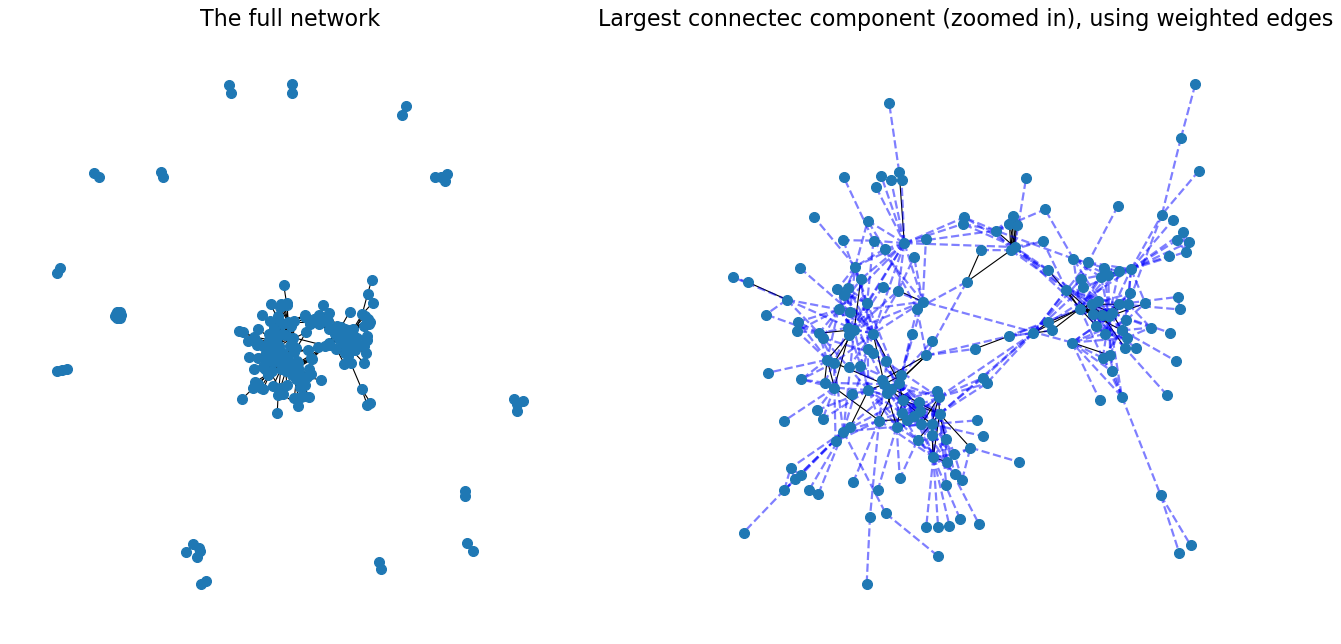

In [51]:

# YOU CAN EDIT THIS TO CHANGE THE USED META-PATH
selected_mp = "BIB"

# Check if the homogeneous graph is present in cache
# If not, create it
data_folder = Path("./homogeneous_graphs/") 
file_to_check = data_folder / (selected_mp + ".gpickle")

if not file_to_check.exists():
    query = metapaths[selected_mp]
    hg = hintohg.rdf_to_homogeneous_endpoint(query)
    nx.write_gpickle(hg, data_folder / (selected_mp + ".gpickle"))
    print("HG saved in folder \"homogeneous_graphs\"")
else:
    hg = nx.read_gpickle(data_folder / (selected_mp + ".gpickle")) 
    print("HG imported")


# Get the largest component of the graph
components = nx.connected_components(hg)
largest_component_size = max(components, key=len)
hg_lcc = hg.subgraph(largest_component_size)

# Draw the network
from matplotlib.pyplot import figure
pos = nx.spring_layout(hg, seed=7)  # positions for all nodes - seed for reproducibility
figure(figsize=(20, 10), dpi=80)

subax1 = plt.subplot(121)
plt.title("The full network", fontsize=20)
nx.draw(hg, pos, node_size = 80, with_labels=False)
subax2 = plt.subplot(122)

plt.title("Largest connectec component (zoomed in), using weighted edges", fontsize=20)
# Draw the nodes and the weighted edges
elarge = [(u, v) for (u, v, d) in hg_lcc.edges(data=True) if d["weight"] > 2]
esmall = [(u, v) for (u, v, d) in hg_lcc.edges(data=True) if d["weight"] <= 2]
nx.draw_networkx_nodes(hg_lcc, pos, node_size=80)
nx.draw_networkx_edges(hg_lcc, pos, edgelist=elarge, width=1)
nx.draw_networkx_edges(
    hg_lcc, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="b", style="dashed"
)
plt.axis("off")
# nx.draw(hg_lcc, node_size = 80, with_labels=False)


<h1>Creating the snaphsot graph(s) and performing dynamic community detection (dcd)</h1>

<p>Here, the snapshot graphs will be created and dcd will be performed, using a time interval and a shift. These values may be changed.<p>

In [57]:
interval = 20
shift = 10

snapshot_graph = dynamic_cd.create_snapshot_graph(hg, interval, shift)
theta = 0.3
(dcd_results_init_partition, tc, snapshots, snapshot_times) = dynamic_cd.execute_dcd({f"{interval}_{shift}" : snapshot_graph})
dynamic_coms = dynamic_cd.matching(tc, theta)

Interval: 20, Stepsize: 10
Num of snapshots: 27
Handling sg with parameters: 20_10
MERGING [6, 7]
MERGING [6, 7]
MERGING [22, 25]
MERGING [22, 25]
MERGING [37, 43]
MERGING [37, 43]
MERGING [9, 49]
MERGING [9, 49]
MERGING [58, 65]
MERGING [42, 57]


In [56]:
name = "Romeyn de Hooghe"
res = dynamic_cd.find_dyn_com(dynamic_coms, name, tc, snapshots, snapshot_times)

NAME TO FIND: Romeyn de Hooghe
12_2
13_0
14_0
15_2
16_3
17_4
TIMESTEP: 12
DYNAMIC COMMUNITY: 30
INTERVAL (1657, 1677)
Romeyn de Hooghe
Samuel Dircksz van Hoogstraten
Jonas Andriesz Suyderhoef
Salomon Savery
Aelbert Jacobsz. Cuyp
Nicolaes Cornelisz Witsen
Gerard Coeck
---------
TIMESTEP: 13
DYNAMIC COMMUNITY: 30
INTERVAL (1667, 1687)
Romeyn de Hooghe
Aldert Meyer
Thomas Doesburgh
Samuel Dircksz van Hoogstraten
Jonas Andriesz Suyderhoef
Salomon Savery
Aelbert Jacobsz. Cuyp
Nicolaes Cornelisz Witsen
Gerard Coeck
---------
TIMESTEP: 14
DYNAMIC COMMUNITY: 30
INTERVAL (1677, 1697)
Jan Jansz. van der Heyden
Romeyn de Hooghe
Aldert Meyer
Thomas Doesburgh
Samuel Dircksz van Hoogstraten
Jonas Andriesz Suyderhoef
Salomon Savery
Aelbert Jacobsz. Cuyp
Jan van Vianen
---------
TIMESTEP: 15
DYNAMIC COMMUNITY: 38
INTERVAL (1687, 1707)
Jan Jansz. van der Heyden
Romeyn de Hooghe
Carel Allard
Johannes de Broen I
Nanteuil, Robert
Bastiaen Stopendael
---------
TIMESTEP: 16
DYNAMIC COMMUNITY: 38
INTERVAL (1